In [1]:
import numpy as np
import pptk
import networkx as nx
import imageio
import glob
import re
from random import sample, seed
from scipy.spatial import distance
from time import strftime
import os
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
import time
import copy
from moving_least_square import *
from tempfile import TemporaryFile
from collections import defaultdict
from vpython import *
from math import *
scene = canvas()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
seed(20)
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [23]:
# Given the data points, return the MST of the point cloud generated from the PNG files and an array 
# of points positions
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#        drawMST: boolean value. Default is false. If set true, the function will also draw a MST graph at the end
#        sampleNumber: int value. Default is 5000. This function will only sample <sampleNumber> points from the data
# Return: a NetworkX graph representing the Minimum spanning tree of the data points
def getMSTFromDataPoint(data, drawMST: bool=False, sampleNumber: int=5000, sliceThickness:float):
    # Read points data from PNGs 
    if(sampleNumber > len(data)):
        sampleNumber = len(data)
        
    # default sample 5000 points from the whole set, otherwise it would take too long
    print("---------------")
    print("There are " + str(len(data)) + " points in total. Now sampleling " + str(sampleNumber) + " points from them")
    sample_data = np.asarray(sample(list(data), sampleNumber))
    print("---------------")
    print("Done!")
    
    #display the points 
    #displayPoints(sample_data, 1.3)
    
    #Create a networkX graph instance that represent MST
    print("---------------")
    print("Begin creating a MST of the sampled points cloud")
    MST = CreateMSTGraph(sample_data)
    print("---------------")
    print("MST creation Done!")
    
    if(drawMST):
        nx.draw(MST, dict(enumerate(sample_data[:, :2])))
        
    return (MST, sample_data)
    

SyntaxError: non-default argument follows default argument (<ipython-input-23-1f7992c22f96>, line 7)

In [4]:
# This function will invoke a pptk viewer to render the points 
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#       pointSize: the size of the point to be rendered on the screen
# Return: none

def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)

In [5]:
# This function will read a txt file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate should has the format of [x, y, z]
# Param: filePath: the file path of the txt file
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def readPointFromTXT(filePath):
    data = np.genfromtxt(fname=filePath, skip_header=0)
    return data

In [6]:
# This function will read a series of PNG file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate will have the format of [x, y, z]
# Param: filePath: the file path of the PNG files. Each file should be named as 1.png, 2.png, 3.png ... etc. All the png file should 
#                  be ordered by the their topological order from their original dicom file
#        orientation: 0, 1, or 2. 0 stands for coronal. 1 stands for transverse. 2 stands for sagittal.
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def ReadPointFromPNG(filepath, orientation:int, padding:int):
    print("---------------")
    print("Begin reading points data from PNG files")
    path_list = [im_path for im_path in glob.glob(filepath)]
    
    if system_win:
        path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    else:
        path_list_parsed = [re.split('/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    
    print("There are", len(path_list_parsed_valid),"PNG files, now convert them to point coordinates in 3D")
    imageData = []
    
    for path in path_list_parsed_valid:
        s = ""
        if system_win:
            s = "\\"
        else:
            s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        
        for i in range(padding):
            imageData.append(image)
    
    
    # Transfrom the matrix to list of points' coordinate whose grey scalse is not 0 (colon area)
    if(orientation == 0):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [1, 2, 0]]
        #xyz[:, 2] = xyz[:, 2]*3*thickness
        
    elif(orientation == 1):
        yxz = np.transpose(np.where(imageData))
        xyz = yxz[:, [1, 0, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
        
    elif(orientation == 2):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [0, 1, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
    
    else:
        print("Orientation shoud only be one of 0, 1 or 2 only.  0 stands for coronal. \
        1 stands for transverse. 2 stands for sagittal.")
        
    print("Done!")
    return xyz

In [7]:
# This function is used to limited the number of edges in the original graph.
# Instead of creating a graph with full connectivity, this function will return 
# a list of neighbor points for each point and we will only connect them in the graph
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# return: a tuple(closestIndices, closesDis). ClosestIndices is a matrix of each point's neighbors. 
#         closestDis is a matrix of the distances between each point and their neighbors

def getNearbyPoints(pointsData):
    D = distance.squareform(distance.pdist(pointsData))
    closestIndicies = np.argsort(D, axis=1)
    closestDis = np.sort(D, 1)
    threshold = 10 # This number can be changed. The greater this number, the more edges
    return (closestIndicies[:, 1:threshold], closestDis[:, 1:threshold])

In [8]:
# This function converts points' coordinate data into a minimum spanning tree. In this graph, the nodes are the points
# from the points cloud and the edges are the connection between each point and their neighbors. The weights are each 
# connection's distance in space
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# Return: A networkX instance containing the MST

def CreateMSTGraph(pointsData):
    print("---------------")
    print("Begin calculating nearby points for each point")
    nearbyInfo = getNearbyPoints(pointsData)
    print("---------------")
    print("Nearby points calculation Done!")
    print("---------------")
    print("Begin construct graph")
    G=nx.Graph()
    closestIndicies = nearbyInfo[0]
    closestDis = nearbyInfo[1]
    for firstPIndex in range(len(closestIndicies)):
        for second in range(len(closestIndicies[firstPIndex])):
            secondPIndex = closestIndicies[firstPIndex][second]
            G.add_edge(firstPIndex, secondPIndex , weight = closestDis[firstPIndex][second])
    print("---------------")
    print("Graph construction Done!")
    print("---------------")
    print("Begin calculate MST")
    G = nx.minimum_spanning_tree(G)
    print("---------------")
    print("MST calculation Done!")
    return G

In [9]:
# Impliment the collect algorithm for 3D points in the paper. This is a recursive function which may not be efficient 
# enough for the project. The non-Recursive version is right below.

def collectPoints1(P: int, PStar: int):
    global H_glo
    global graph
    global pointsCor3D
    global A

    A.append(P)
    for edge in graph.edges(P):
        Pj = edge[1]
        if(Pj) not in A and distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar]) < H_glo:
            collectPoints1(Pj, PStar)

In [10]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
#        H: the searching range for the neighbors
# Return: A: A set of points' indicies representing the neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 

def collectPointsNonrec(PStar: int, H:int):
    
    global graph
    global pointsCor3D
    global distance_dict 
    global dirty_dict
    
    toExplore = [PStar]
    A = [PStar]
    distance_dict[(PStar, PStar)] = 0
    weight_dict[((PStar, PStar))] = 1
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        for Pj in graph.neighbors(curP):
            if(Pj) not in A:
                
                # Maintain the dictionary of distance and weight between points
                if (Pj, PStar) not in distance_dict or (PStar, Pj) not in distance_dict or \
                dirty_dict[PStar] == 1 or dirty_dict[Pj] == 1:
                    dist_temp = distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar])
                    distance_dict[(Pj, PStar)] = dist_temp
                    distance_dict[(PStar, Pj)] = dist_temp
                    weight_dict[((PStar, Pj))] = weightFun(PStar, Pj)
                    weight_dict[((Pj, PStar))] = weightFun(PStar, Pj)
                    dirty_dict[Pj] = 0
                    dirty_dict[PStar] = 0
                    
                if distance_dict[(Pj, PStar)] < H:
                    toExplore.append(Pj)
                    A.append(Pj)
    return A

In [11]:
# Calculate the weight between any tew points. This weight is used to calculate regression plane
# Params: P1: the index of the first point
#         P2: the index of the second point
# Return: the weight between the two points

def weightFun(P1, P2):
    global distance_dict 
    global dirty_dict
    global pointsCor3D
    if(P1 == P2):
        return 1
    return math.exp(-1 * (distance_dict[(P1, P2)]**2)/(H_glo**2))

In [12]:
# Calculate the regression plane for a specific point given its neighbors. 
# Params: PStar: the index of the point for which we want to find the gression plane.
#         A: A set of points' indicies representing PStar's neighbors
# Return: fitted_params: the regression plane's parameters, which is the A, B, C in Ax + By + C - z = 0

def calculateRegressionPlane(PStar, A: list):
    global pointsCor3D
    global H_glo
    global weight_dict
    global curPlaneGuess
    
    # The following code is used for a dynamic programming version. But currently there is no perfermance improvement 
    # using this technique. Need to explore further
    # global curScalar
    # global curALen
    '''
    weightKeyList = [(PStar, x) for x in A[curALen:]]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A[curALen:]])
    yMatrix = np.array([pointsCor3D[point][1] for point in A[curALen:]])
    zMatrix = np.array([pointsCor3D[point][2] for point in A[curALen:]])
    scalarList = np.array([np.sum(xMatrix**2*wM), 2*np.sum(xMatrix*yMatrix*wM), 2*np.sum(xMatrix*wM), \
                           -2*np.sum(xMatrix*zMatrix*wM), np.sum(yMatrix**2*wM), 2*np.sum(yMatrix*wM), \
                           -2*np.sum(yMatrix*zMatrix*wM), np.sum(wM) ,-2*np.sum(zMatrix*wM), \
                           np.sum(zMatrix**2*wM)]) + curScalar
    '''
    
    weightKeyList = [(PStar, x) for x in A]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A])
    yMatrix = np.array([pointsCor3D[point][1] for point in A])
    zMatrix = np.array([pointsCor3D[point][2] for point in A])
    
    def f(params):
        a, b, c = params 
        loss = sum(((a * xMatrix + b*yMatrix + c - zMatrix)**2)*wM)
        
        # Dynamic programming version
        #loss = a**2*scalarList[0] +  a*b*scalarList[1] + a*c*scalarList[2] + a*scalarList[3] + b**2*scalarList[4]\
        #+ b*c*scalarList[5] + b*scalarList[6] + c**2*scalarList[7] + c*scalarList[8] + scalarList[9]
        
        return loss
    
    result = optimize.minimize(f, curPlaneGuess, method = 'Nelder-Mead')
    
    if result.success:
        fitted_params = result.x
    else:
        raise ValueError(result.message)
        
    curPlaneGuess = fitted_params
    #curScalar = scalarList
    #curALen = len(A)
    
    return fitted_params

In [13]:
# This function projects a list of points to a plane specified using 'params' and return their coordinate after the
# projection in 3D
# Param: params: a plane's parameters, which is the A, B, C in Ax + By + C - z = 0
#        A: a list of points (points' indices) that need to be projected

def projectPoints(params, A: list):
    global pointsCor3D
    a, b, c = params
    normal = np.asarray([a, b, -1])
    normal = normal / np.linalg.norm(normal)
    pointOnPlane = np.asarray([0, 0, c])
    projectionPointsCor = []
    for point in A:
        point_cor = np.asarray(pointsCor3D[point])
        pointToPlaneV = point_cor - pointOnPlane
        dist = np.dot(normal, pointToPlaneV)
        projectionPointcor = point_cor - dist*normal
        projectionPointsCor.append(list(projectionPointcor))
    return projectionPointsCor

In [14]:
# This function converted the 3D coordinate system of points in a plane to 2D, returns a list of new coordinates
# each of them also has x, y and z component but z is equal to 0
# this finction also will return the info of the plane, which can be used to convert a 2D coordinate to 3D again
# The format of the plane info is [u, v, origin] (u is a unit vector in 3D representing plane's x axis, y is a unit 
# vector in 3D representing plane's y axis, origin is a coordinate in 3D of plane's origin )

def convertTo2DCor(pointsCor, planeParam):
    a, b, c = planeParam
    origin = np.array([0, 0, c])
    u = np.array([0, 0, c]) - np.array([1, 1, a + b + c])
    u = u / np.linalg.norm(u)
    normal = np.array([a, b, -1])
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    convertedPointsCor = []
    
    for pointCor in pointsCor:
        oriV = np.array(pointCor) - origin
        new_x = np.dot(oriV, u)
        new_y = np.dot(oriV, v)
        convertedPointsCor.append([new_x, new_y, 0])
        
    planeInfo = [u, v, origin]
    
    return (convertedPointsCor, planeInfo)
    

In [15]:
# Param: targetPoint: the index of the point that we want to find its neighbors and their coordinate in 2D 
# Return: the 2D coordinate of the 3D points and the information of the regression plane, which the points are located
# require gloable perameters graph and pointsCor3D

def get2DCorFrom3D(targetPoint):
    
    global graph
    global pointsCor3D
    global H_glo
    global H_delta
    global min_neighbors
    
    localPoints = []

    while (len(localPoints) < min_neighbors):
        localPoints = collectPointsNonrec(targetPoint, H_glo)
        if(len(localPoints) < min_neighbors):
            H_glo += H_delta

    params = calculateRegressionPlane(targetPoint, localPoints)

    projectionPointsCor = projectPoints(params, localPoints)

    points2DCor, planeInfo = convertTo2DCor(projectionPointsCor, params)

    return (points2DCor, planeInfo)

In [16]:
# This function takes a single point's 2D coordinate and transform it into 3D base on the planeInfo
def get3DCorFrom2D(pointCor, planeInfo):
    u, v, origin = planeInfo
    vectorElem1 = pointCor[0]*u
    vectorElem2 = pointCor[1]*v
    newCor = vectorElem1 + vectorElem2 + origin
    
    return newCor

In [17]:
#compue the line regression
def calculateRegressionLine(pointsCor):
    X = np.array([x[0] for x in pointsCor]).reshape(-1, 1)
    Y = np.array([x[1] for x in pointsCor]).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    return(linear_regressor.coef_[0], linear_regressor.intercept_[0])

In [18]:
def rotatePointsCor(pointsCor, lineCoef):
    pointsCor = np.array(pointsCor)
    theta = math.atan(lineCoef)
    c, s = math.cos(theta), math.sin(theta)
    R = np.array([(c,-s, 1), (s, c, 1)])
    newPointsCor = []
    
    for point in pointsCor:
        newPointsCor.append(R.dot(point))
    return np.asarray(newPointsCor)

In [19]:
# This function is used to reconstruct the end point of the centerline after cleaning

def deleteChild(child:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    graph_centerline.remove_node(child)
    
    for grandChild in removedNodeDict[child]:
        if(graph_centerline.has_node(grandChild)):
            deleteChild(grandChild)
        

In [20]:
# This function is used to reconstruct the end point of the centerline after cleaning

def addBackChildren(parent:int, curDepth:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    if(parent not in removedNodeDict):
        return curDepth
    
    if(len(removedNodeDict[parent]) == 1):
        child = removedNodeDict[parent][0]
        parent_cor = pointsCor3D_centerline[parent]
        child_cor = pointsCor3D_centerline[child]
        graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
        return addBackChildren(child, curDepth + 1)
    
    else:
        maxDepth = 0
        curChild = -1
        
        for child in removedNodeDict[parent]:
            parent_cor = pointsCor3D_centerline[parent]
            child_cor = pointsCor3D_centerline[child]
            graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
            childDepth = addBackChildren(child, curDepth + 1)
            
            if(childDepth < maxDepth):
                deleteChild(parent, child)
            else:
                maxDepth = childDepth
                
                if(curChild != -1):
                    deleteChild(curChild)
                    
                curChild = child           
        return maxDepth
     

In [21]:
# This function is used for visulize the centerline in VPython

def pointCorToVector(pointCor):
    x = pointCor[0]
    y = pointCor[1]
    z = pointCor[2]
    return vector(x, y, z)

In [22]:
filePath = "mri_label_2016/*.png"
pointData = ReadPointFromPNG(filePath, 0, 4)
(graph, pointsCor3D) = getMSTFromDataPoint(pointData, drawMST=False, sampleNumber=5000)

---------------
Begin reading points data from PNG files
There are 144 PNG files, now convert them to point coordinates in 3D
Done!


NameError: name 'getMSTFromDataPoint' is not defined

In [69]:
displayPoints(pointsCor3D, 1.3)

In [74]:
# the code to move points toward the centerline 
points_centerline = []

# The total number of iterations
for iteration in range(2):
    points_centerline = []
    H_ini = 20
    H_delta = 3
    H_glo = 0
    trial_limit =20
    min_neighbors = 150
    max_neighbors = 750
    correlation_threshold = 0.2 + iteration*0.05
    weight_dict = {}
    distance_dict = {}

    # Set up a dirty dictionary to record the points that has been moved
    dirty_dict = {}
    for point in range(len(pointsCor3D)):
        dirty_dict[point] = 0
    results = []
    
    # We will move 750 points of all the points for each iteration
    for targetPoint in range(2000, 3000):
        
        cur_correlation = 0
        H_glo = H_ini
        trial = 0
        correlation_hist = []
        localPointsCor2D_hist = []
        planeInfo = 0
        localPointsCor2D = []
        curPlaneGuess = [1, 1, 1]
        # The next two lines are used in a dynamic programming version of computing the centerline
        #curScalar = np.zeros(10)
        #curALen = 0
        
        # if the correlation of the local points is not sufficient or the number of the local points is not sufficient
        # enlarge H_glo and find neighbors again  
        while(cur_correlation < correlation_threshold and len(localPointsCor2D) < max_neighbors \
               and trial < trial_limit):
            
            #curPlaneGuess = [1, 1, 1]
            localPointsCor2D, planeInfo = get2DCorFrom3D(targetPoint)
            
            slope, intersept = calculateRegressionLine(localPointsCor2D)
            rotatedPointsCor = rotatePointsCor(localPointsCor2D, slope)
            cur_correlation = abs(np.corrcoef(rotatedPointsCor[:, 0],rotatedPointsCor[:, 1])[0][1])
            print(targetPoint, "trial",str(trial), "H =", H_glo, ":" , str(cur_correlation), \
                  "size:", len(localPointsCor2D))
            H_glo += H_delta
            trial += 1
            correlation_hist.append(cur_correlation)
            localPointsCor2D_hist.append(copy.deepcopy(localPointsCor2D))
            
        localPointsCor2D = localPointsCor2D_hist[correlation_hist.index(max(correlation_hist))]
        centerPoint2D = np.asarray(localPointsCor2D)[:1, :2]
        newCor = Moving_Least_Square(centerPoint2D[0], np.asarray(localPointsCor2D)[:, :2])
        newCor3D = get3DCorFrom2D(newCor, planeInfo)
        print(pointsCor3D[targetPoint], newCor3D)
        pointsCor3D[targetPoint] = list(newCor3D)
        dirty_dict[targetPoint] = 1
        results.append(max(correlation_hist))
        points_centerline.append(newCor3D)
        
    displayPoints(points_centerline, 0.5)    

2000 trial 0 H = 59 : 0.7252991329535904 size: 188
[224 444 211] [225.72201325 444.29642676 212.38412526]
2001 trial 0 H = 56 : 0.10994958942910447 size: 176
2001 trial 1 H = 62 : 0.3679219668066277 size: 193
[236 445 196] [235.91378717 443.6002711  198.76576549]
2002 trial 0 H = 41 : 0.5952220303880454 size: 153
[330 376 180] [330.39502583 376.36532197 180.03687037]
2003 trial 0 H = 44 : 0.692460915623838 size: 153
[321 389 182] [321.42648124 389.42285162 182.28631958]
2004 trial 0 H = 44 : 0.618467831228842 size: 157
[120 395 172] [118.28220739 393.20423178 171.63615946]
2005 trial 0 H = 68 : 0.8188380346709139 size: 162
[215 440 226] [218.28067317 441.72648503 226.28108177]
2006 trial 0 H = 38 : 0.2144035717697226 size: 156
[262 434 182] [262.97215026 436.23513171 179.14699797]
2007 trial 0 H = 62 : 0.8192811145431815 size: 151
[198 439 253] [201.02533022 439.66036222 255.27981788]
2008 trial 0 H = 44 : 0.16187571055040176 size: 161
2008 trial 1 H = 50 : 0.2989140919390659 size: 200

[ 85 366 167] [ 87.68316135 369.12424222 165.20478937]
2046 trial 0 H = 41 : 0.04802331611103929 size: 153
2046 trial 1 H = 47 : 0.07055158876787153 size: 185
2046 trial 2 H = 53 : 0.10471322353928002 size: 206
2046 trial 3 H = 59 : 0.34417415077462604 size: 254
[ 86 318 129] [ 86.38669009 318.38328777 129.17905553]
2047 trial 0 H = 50 : 0.48934804576968377 size: 152
[167 423 339] [166.71708131 422.6476417  340.90134538]
2048 trial 0 H = 53 : 0.2647182022149257 size: 158
[359 359 108] [358.47088685 358.61969103 108.28556843]
2049 trial 0 H = 44 : 0.10096246744403616 size: 180
2049 trial 1 H = 50 : 0.031406782935471056 size: 227
2049 trial 2 H = 56 : 0.14057474775379142 size: 275
2049 trial 3 H = 62 : 0.012835407418986314 size: 345
2049 trial 4 H = 68 : 0.07677471455607957 size: 472
2049 trial 5 H = 74 : 0.0530299417879084 size: 516
2049 trial 6 H = 80 : 0.01180203694566758 size: 561
2049 trial 7 H = 86 : 0.046828609852769126 size: 693
2049 trial 8 H = 92 : 0.06800337263468359 size: 718

2090 trial 3 H = 65 : 0.10003978943810697 size: 300
2090 trial 4 H = 71 : 0.47012196992318994 size: 348
[122 162 107] [122.51109805 162.68264345 107.77573452]
2091 trial 0 H = 38 : 0.006195946359306491 size: 158
2091 trial 1 H = 44 : 0.2821091968920007 size: 250
[152 260 111] [150.70988306 258.4487491  109.07705735]
2092 trial 0 H = 38 : 0.18867922783477614 size: 176
2092 trial 1 H = 44 : 0.19072045082248734 size: 220
2092 trial 2 H = 50 : 0.1983719541257004 size: 244
2092 trial 3 H = 56 : 0.1250643537327196 size: 333
2092 trial 4 H = 62 : 0.01878615323155354 size: 465
2092 trial 5 H = 68 : 0.016915041349580738 size: 505
2092 trial 6 H = 74 : 0.01967781961950226 size: 554
2092 trial 7 H = 80 : 0.08825821517742355 size: 603
2092 trial 8 H = 86 : 0.12030488036027386 size: 625
2092 trial 9 H = 92 : 0.13697411438972476 size: 1063
[240  89 153] [235.27242416  92.60192977 157.82640354]
2093 trial 0 H = 47 : 0.6876456570644379 size: 152
[143 417 346] [142.46066878 416.38469553 345.02080934]
2

2134 trial 0 H = 50 : 0.4702906626524781 size: 165
[121 398 264] [121.37181034 397.90810886 265.23725112]
2135 trial 0 H = 41 : 0.2249370233274568 size: 166
[353 352 170] [355.87331593 354.90858273 171.36887236]
2136 trial 0 H = 47 : 0.7103242184348705 size: 151
[324 385 168] [324.2694102  385.22282393 176.76003329]
2137 trial 0 H = 50 : 0.24747321054574314 size: 161
[176 162 143] [176.79270702 161.93814802 145.32301496]
2138 trial 0 H = 65 : 0.3689376314710083 size: 159
[205 417 303] [205.14127436 417.25059465 298.59981962]
2139 trial 0 H = 41 : 0.024585835896249138 size: 153
2139 trial 1 H = 47 : 0.10709031689010072 size: 191
2139 trial 2 H = 53 : 0.07333300488138134 size: 221
2139 trial 3 H = 59 : 0.3965173343028263 size: 422
[283  93 171] [283.53646045  93.00880663 175.3801796 ]
2140 trial 0 H = 50 : 0.37856255694288604 size: 153
[175 165 146] [175.87255263 165.210082   148.01247767]
2141 trial 0 H = 35 : 0.0028523760280854933 size: 157
2141 trial 1 H = 41 : 0.05580645410046511 siz

2184 trial 1 H = 50 : 0.10233897596772067 size: 183
2184 trial 2 H = 56 : 0.18541507049326697 size: 219
2184 trial 3 H = 62 : 0.0869550995081038 size: 247
2184 trial 4 H = 68 : 0.16486492628322771 size: 299
2184 trial 5 H = 74 : 0.36695411205846257 size: 390
[ 79 335 138] [ 83.03879809 335.79156307 142.56473792]
2185 trial 0 H = 44 : 0.0437458385483025 size: 297
2185 trial 1 H = 50 : 0.01027201433724794 size: 409
2185 trial 2 H = 56 : 0.023631528203119197 size: 475
2185 trial 3 H = 62 : 0.0065761298874468235 size: 516
2185 trial 4 H = 68 : 0.016090945550796334 size: 713
2185 trial 5 H = 74 : 0.034542280634850826 size: 831
[182 101 152] [185.14529713 106.40012708 147.83748036]
2186 trial 0 H = 38 : 0.2406954845047115 size: 155
[144 279 119] [145.03556373 280.23154027 120.4090272 ]
2187 trial 0 H = 44 : 0.10791737185448311 size: 153
2187 trial 1 H = 50 : 0.10859216528915616 size: 190
2187 trial 2 H = 56 : 0.2907261886798281 size: 209
[368 347 119] [368.23981597 347.24845057 119.23278273]

[295 126 196] [296.18168696 127.45986058 195.54632218]
2224 trial 0 H = 47 : 0.7729558874933175 size: 167
[320 393 192] [320.07238869 393.50527409 182.81924442]
2225 trial 0 H = 38 : 0.08027333767162319 size: 156
2225 trial 1 H = 44 : 0.31010305115412107 size: 212
[244  87 160] [244.82965407  87.99961081 156.81122172]
2226 trial 0 H = 65 : 0.6104788805064361 size: 209
[379 251 166] [384.64137711 256.92546403 167.68669116]
2227 trial 0 H = 44 : 0.5003139264505957 size: 153
[129 412 346] [129.4195087  412.42127709 346.04821501]
2228 trial 0 H = 44 : 0.5939686632817609 size: 158
[120 396 168] [116.39750601 393.02189299 169.56853208]
2229 trial 0 H = 92 : 0.304231451676506 size: 155
[242 166 259] [242.27968746 168.03804029 258.07074243]
2230 trial 0 H = 44 : 0.8003783954130789 size: 153
[322 391 177] [321.81407506 390.81157612 177.81315609]
2231 trial 0 H = 47 : 0.26469594183123585 size: 172
[ 99 403 305] [ 97.66867536 401.50256644 304.66551702]
2232 trial 0 H = 47 : 0.014126807462540717 s

2265 trial 3 H = 59 : 0.060203506544921105 size: 465
2265 trial 4 H = 65 : 0.15011345226362646 size: 587
2265 trial 5 H = 71 : 0.14719739706761698 size: 621
2265 trial 6 H = 77 : 0.1622465318528537 size: 805
[224  92 167] [224.66449013  91.58332296 162.55486486]
2266 trial 0 H = 50 : 0.7365515308669855 size: 158
[131 402 177] [126.11533595 397.569312   176.43392242]
2267 trial 0 H = 65 : 0.317515712005552 size: 155
[205 414 300] [206.38405874 415.41722629 297.21282561]
2268 trial 0 H = 44 : 0.34217129857629325 size: 150
[365 344 109] [365.41750195 344.37857826 108.75338623]
2269 trial 0 H = 38 : 0.03500411207043528 size: 151
2269 trial 1 H = 44 : 0.1131293973691665 size: 230
2269 trial 2 H = 50 : 0.21952253226743576 size: 316
[131 228  93] [132.72591252 229.895055    92.96596327]
2270 trial 0 H = 50 : 0.15403519391315432 size: 178
2270 trial 1 H = 56 : 0.28754007092604095 size: 273
[262  74 157] [261.67474506  78.49641276 167.71112585]
2271 trial 0 H = 50 : 0.03837608384319613 size: 17

2311 trial 0 H = 41 : 0.03862490365329478 size: 183
2311 trial 1 H = 47 : 0.057338096539527345 size: 333
2311 trial 2 H = 53 : 0.02022450207181442 size: 415
2311 trial 3 H = 59 : 0.01620464081143636 size: 479
2311 trial 4 H = 65 : 0.01782053326193747 size: 581
2311 trial 5 H = 71 : 0.008156883097654893 size: 714
2311 trial 6 H = 77 : 0.000679111091493882 size: 850
[178  99 151] [183.60612016 106.1597916  145.94772301]
2312 trial 0 H = 44 : 0.08725239434062564 size: 161
2312 trial 1 H = 50 : 0.11350630265328675 size: 189
2312 trial 2 H = 56 : 0.20895675092340743 size: 218
[ 99 397 285] [ 99.26252358 397.85686018 284.68553122]
2313 trial 0 H = 62 : 0.09852422704919231 size: 744
2313 trial 1 H = 68 : 0.06135678758581048 size: 816
[195 105 157] [199.88893857 108.87197533 152.01913314]
2314 trial 0 H = 44 : 0.4831374468760215 size: 155
[120 412 343] [121.11678182 413.29904589 344.80873848]
2315 trial 0 H = 56 : 0.594562849121534 size: 156
[308 414 195] [309.3138476  414.54734212 191.2868832

2363 trial 4 H = 62 : 0.010768997184897473 size: 674
2363 trial 5 H = 68 : 0.015179519989630222 size: 809
[181 116 146] [188.15427009 126.03162796 142.05100173]
2364 trial 0 H = 44 : 0.10892441434718844 size: 155
2364 trial 1 H = 50 : 0.6419344006961473 size: 174
[295 426 179] [295.33427151 425.76553573 176.86008726]
2365 trial 0 H = 62 : 0.38686652751432193 size: 152
[170 397 247] [170.43398118 396.81204419 241.81836205]
2366 trial 0 H = 35 : 0.07186935158082827 size: 152
2366 trial 1 H = 41 : 0.022107567874138607 size: 171
2366 trial 2 H = 47 : 0.03035650663250545 size: 188
2366 trial 3 H = 53 : 0.21807577973227732 size: 215
[138 149 115] [139.73537422 149.65220068 112.43337206]
2367 trial 0 H = 44 : 0.30190470026131627 size: 185
[258 438 179] [257.72904441 438.36480292 177.43548492]
2368 trial 0 H = 53 : 0.05889537932639413 size: 261
2368 trial 1 H = 59 : 0.43880830182578034 size: 401
[138 197  95] [135.21269337 194.36900679  95.58649647]
2369 trial 0 H = 68 : 0.19943082699878514 si

2413 trial 0 H = 38 : 0.055000628524935126 size: 196
2413 trial 1 H = 44 : 0.13392232055226072 size: 239
2413 trial 2 H = 50 : 0.13519429282121612 size: 301
2413 trial 3 H = 56 : 0.04866223446021043 size: 478
2413 trial 4 H = 62 : 0.007046096937761538 size: 698
2413 trial 5 H = 68 : 0.004710766557292539 size: 901
[174 121 140] [182.44940499 129.83415831 136.65775399]
2414 trial 0 H = 41 : 0.0698374120599291 size: 156
2414 trial 1 H = 47 : 0.07241851056705446 size: 184
2414 trial 2 H = 53 : 0.09975083354822643 size: 206
2414 trial 3 H = 59 : 0.35312413248008884 size: 255
[ 86 318 128] [ 86.63493071 318.22298496 128.7907472 ]
2415 trial 0 H = 38 : 0.04301998853719625 size: 159
2415 trial 1 H = 44 : 0.03229099756919848 size: 183
2415 trial 2 H = 50 : 0.16810641481901034 size: 200
2415 trial 3 H = 56 : 0.00721831698438303 size: 271
2415 trial 4 H = 62 : 0.13638208495521137 size: 290
2415 trial 5 H = 68 : 0.2792807425120023 size: 317
[129 154 105] [129.87320121 156.29382557 110.1254125 ]
24

2455 trial 1 H = 50 : 0.18979644647515417 size: 196
2455 trial 2 H = 56 : 0.3527954310393207 size: 360
[291 136 205] [291.3982856  136.76877618 204.41015525]
2456 trial 0 H = 35 : 0.037674595280332 size: 155
2456 trial 1 H = 41 : 0.19884332886804254 size: 184
2456 trial 2 H = 47 : 0.03480198701912828 size: 211
2456 trial 3 H = 53 : 0.03524447982743769 size: 227
2456 trial 4 H = 59 : 0.14797885557425097 size: 253
2456 trial 5 H = 65 : 0.3217074500625164 size: 306
[ 93 381 164] [ 95.57002527 383.50804663 165.38276903]
2457 trial 0 H = 44 : 0.06373564288279938 size: 153
2457 trial 1 H = 50 : 0.22036239880254774 size: 193
[372 351 164] [369.62060957 352.62967574 160.6252437 ]
2458 trial 0 H = 41 : 0.1067679069652291 size: 162
2458 trial 1 H = 47 : 0.2624709192502205 size: 186
[ 80 390 166] [ 81.61635888 391.49535447 166.85195756]
2459 trial 0 H = 59 : 0.5802710446842116 size: 152
[159 398 251] [157.28526637 402.32471723 245.74567913]
2460 trial 0 H = 38 : 0.4963379806173051 size: 154
[ 86 

2504 trial 0 H = 44 : 0.055362832718804315 size: 182
2504 trial 1 H = 50 : 0.3499066491768863 size: 313
[142 262 107] [143.93548865 263.38736492 108.80552864]
2505 trial 0 H = 38 : 0.019886670052862016 size: 162
2505 trial 1 H = 44 : 0.0030401004202183046 size: 193
2505 trial 2 H = 50 : 0.008333308130316849 size: 242
2505 trial 3 H = 56 : 0.062262815402569 size: 276
2505 trial 4 H = 62 : 0.2040154324625274 size: 303
[116 168 107] [116.08519332 170.39297333 107.05045112]
2506 trial 0 H = 47 : 0.35532467536277845 size: 173
[153 126 128] [155.72607619 129.72293533 128.26155274]
2507 trial 0 H = 44 : 0.794833089752407 size: 152
[322 388 183] [322.76591323 389.04278344 180.12327909]
2508 trial 0 H = 98 : 0.6559532313226186 size: 157
[210 175 220] [208.78168462 173.01964646 211.48853541]
2509 trial 0 H = 71 : 0.1289268480063444 size: 151
2509 trial 1 H = 77 : 0.18988200285851045 size: 189
2509 trial 2 H = 83 : 0.02400451858725582 size: 201
2509 trial 3 H = 89 : 0.4516549448618196 size: 228
[

2547 trial 1 H = 68 : 0.11788673678009512 size: 204
2547 trial 2 H = 74 : 0.1508536705845858 size: 240
2547 trial 3 H = 80 : 0.38321082424735964 size: 393
[388 297 160] [387.23126902 296.59638    161.44413478]
2548 trial 0 H = 38 : 0.0196106946814272 size: 157
2548 trial 1 H = 44 : 0.021289163788185527 size: 173
2548 trial 2 H = 50 : 0.08532997417779002 size: 201
2548 trial 3 H = 56 : 0.2532699952218371 size: 230
[140 147 118] [142.42676123 147.66473955 114.67625728]
2549 trial 0 H = 35 : 0.008298364409503791 size: 153
2549 trial 1 H = 41 : 0.010922676215828053 size: 190
2549 trial 2 H = 47 : 0.07043245851272101 size: 286
2549 trial 3 H = 53 : 0.12604216879103702 size: 383
2549 trial 4 H = 59 : 0.020490707695641815 size: 568
2549 trial 5 H = 65 : 0.014457658909969981 size: 662
2549 trial 6 H = 71 : 0.007347703929282269 size: 697
2549 trial 7 H = 77 : 0.010293278755802333 size: 976
[190 130 121] [184.8874366  124.04930041 134.06376988]
2550 trial 0 H = 56 : 0.4698539913518457 size: 197


2587 trial 4 H = 74 : 0.047552772686546584 size: 220
2587 trial 5 H = 80 : 0.010780695778506554 size: 264
2587 trial 6 H = 86 : 0.07151535411607755 size: 283
2587 trial 7 H = 92 : 0.03796149287343069 size: 290
2587 trial 8 H = 98 : 0.24434981156557514 size: 416
[367 339 103] [373.88059492 338.26422867 138.16100542]
2588 trial 0 H = 38 : 0.10525504905593826 size: 164
2588 trial 1 H = 44 : 0.0377549839713132 size: 197
2588 trial 2 H = 50 : 0.02660448276802787 size: 223
2588 trial 3 H = 56 : 0.1132680132124638 size: 251
2588 trial 4 H = 62 : 0.2296092343217235 size: 301
[ 98 381 165] [ 98.51579477 381.51967745 165.11556777]
2589 trial 0 H = 56 : 0.6978934052240615 size: 189
[172 428 327] [169.63663857 425.36430652 333.62443995]
2590 trial 0 H = 44 : 0.2788198239615041 size: 256
[299 121 194] [300.2922447  122.69004567 192.69507438]
2591 trial 0 H = 38 : 0.5019207859902883 size: 156
[188 102 137] [186.62900496 100.33731749 135.37521243]
2592 trial 0 H = 53 : 0.41161785707067666 size: 164
[

2632 trial 3 H = 56 : 0.005580986357640611 size: 229
2632 trial 4 H = 62 : 0.07354475839538632 size: 251
2632 trial 5 H = 68 : 0.29786052173941896 size: 306
[ 88 388 165] [ 88.9260323  388.88814026 165.6199878 ]
2633 trial 0 H = 41 : 0.2902700280596948 size: 157
[307  98 180] [305.90552346  97.16627782 177.25560366]
2634 trial 0 H = 50 : 0.6520255187417158 size: 158
[396 261 164] [391.68697901 256.65358618 164.57469412]
2635 trial 0 H = 47 : 0.13007077852525456 size: 163
2635 trial 1 H = 53 : 0.19114924661370072 size: 197
2635 trial 2 H = 59 : 0.26713409589925574 size: 225
[ 81 334 148] [ 80.42263233 336.52159735 143.46406929]
2636 trial 0 H = 47 : 0.15392927080616717 size: 276
2636 trial 1 H = 53 : 0.09434205123289859 size: 366
2636 trial 2 H = 59 : 0.02412411667252562 size: 473
2636 trial 3 H = 65 : 0.003888698601654356 size: 616
2636 trial 4 H = 71 : 0.0003481744422609633 size: 772
[168 111 143] [175.64470623 121.35552558 138.24301967]
2637 trial 0 H = 53 : 0.2225625846972134 size: 

[319 393 183] [320.4766641  394.42822478 183.26369932]
2683 trial 0 H = 44 : 0.04521042855136824 size: 266
2683 trial 1 H = 50 : 0.04649051601515177 size: 350
2683 trial 2 H = 56 : 0.017148681399272243 size: 444
2683 trial 3 H = 62 : 0.10204175313940829 size: 535
2683 trial 4 H = 68 : 0.15745923753418023 size: 593
2683 trial 5 H = 74 : 0.1475833950720212 size: 626
2683 trial 6 H = 80 : 0.1659036927018732 size: 819
[226  90 167] [227.26789074  90.1783341  162.65716637]
2684 trial 0 H = 50 : 0.234045816849994 size: 151
[118 397 266] [119.35905689 398.14128681 266.26668769]
2685 trial 0 H = 80 : 0.6668324801845045 size: 195
[382 232 170] [385.93202265 235.93825857 170.69511433]
2686 trial 0 H = 53 : 0.7516327131176634 size: 193
[129 397 172] [125.05633784 394.90252907 175.39860325]
2687 trial 0 H = 47 : 0.7762806778678591 size: 170
[316 400 183] [316.0657642  400.07283447 183.59774543]
2688 trial 0 H = 47 : 0.3234275411969158 size: 157
[128 297 121] [128.02019156 296.95194845 121.48463892

2724 trial 0 H = 89 : 0.5804681131504842 size: 546
[340 301 168] [373.6744805  334.32921374 161.14623717]
2725 trial 0 H = 74 : 0.8592158310045223 size: 171
[204 443 241] [203.22218136 441.42369788 246.74724148]
2726 trial 0 H = 35 : 0.10838912898174524 size: 150
2726 trial 1 H = 41 : 0.05609597072694574 size: 171
2726 trial 2 H = 47 : 0.03998588659321139 size: 189
2726 trial 3 H = 53 : 0.20615532360119018 size: 214
[137 150 113] [138.42004794 150.82921088 111.4943432 ]
2727 trial 0 H = 53 : 0.2793001888957582 size: 292
[118 191  99] [117.62567829 190.67377124  97.10474157]
2728 trial 0 H = 38 : 0.22294565825458387 size: 155
[144 279 118] [145.2118965  280.37461706 119.69566744]
2729 trial 0 H = 50 : 0.06938601961620078 size: 173
2729 trial 1 H = 56 : 0.024356213951412107 size: 207
2729 trial 2 H = 62 : 0.024181400679829823 size: 224
2729 trial 3 H = 68 : 0.028740461993597272 size: 239
2729 trial 4 H = 74 : 0.06410755376282902 size: 278
2729 trial 5 H = 80 : 0.03521892054472598 size: 2

2761 trial 0 H = 38 : 0.21912093665403204 size: 150
[239  87 167] [240.92280274  88.29510185 159.25558177]
2762 trial 0 H = 41 : 0.2680840402733351 size: 157
[284 431 177] [284.82879543 431.71286675 175.58500585]
2763 trial 0 H = 41 : 0.07552134227030495 size: 153
2763 trial 1 H = 47 : 0.6017618502518692 size: 172
[292 427 175] [292.2933291 427.3084479 175.0734794]
2764 trial 0 H = 71 : 0.8672206938116087 size: 172
[212 438 241] [214.34799162 440.98051161 234.76323425]
2765 trial 0 H = 53 : 0.46826958792952916 size: 161
[400 280 168] [396.09375617 276.50990152 168.49156156]
2766 trial 0 H = 80 : 0.6697041999176181 size: 186
[387 230 175] [387.38620418 229.85545942 172.73090687]
2767 trial 0 H = 56 : 0.39929466408655817 size: 153
[181 175 183] [179.00578887 172.03243645 170.45425507]
2768 trial 0 H = 47 : 0.4835229060317876 size: 158
[270  76 176] [272.16992267  78.33134458 178.3213621 ]
2769 trial 0 H = 38 : 0.19025244769065616 size: 163
2769 trial 1 H = 44 : 0.35323557278703066 size: 

2807 trial 7 H = 92 : 0.018317707968263097 size: 322
2807 trial 8 H = 98 : 0.036865721183168276 size: 333
2807 trial 9 H = 104 : 0.5456377785680065 size: 428
[369 324 103] [377.15153634 330.71747977 141.86055668]
2808 trial 0 H = 44 : 0.34604235431907543 size: 210
[355 351 171] [357.2243856  353.40243388 171.74678504]
2809 trial 0 H = 38 : 0.07280078118548247 size: 157
2809 trial 1 H = 44 : 0.014782366082935216 size: 192
2809 trial 2 H = 50 : 0.14041482723900095 size: 231
2809 trial 3 H = 56 : 0.17761380805389373 size: 269
2809 trial 4 H = 62 : 0.3291346042712307 size: 300
[342 359 178] [342.1852448  359.18473037 177.88014659]
2810 trial 0 H = 56 : 0.6206484366981473 size: 150
[171 175 159] [172.19205923 175.57484671 161.70678789]
2811 trial 0 H = 50 : 0.3183608355292401 size: 158
[ 81 413 310] [ 79.47221178 411.87096225 304.42792242]
2812 trial 0 H = 65 : 0.3552495242908487 size: 154
[191 434 283] [194.97874757 438.06004894 280.40091661]
2813 trial 0 H = 50 : 0.10349511487431236 size:

2852 trial 6 H = 86 : 0.2767728236378092 size: 358
[366 328 117] [371.22453992 337.89529552 139.29401246]
2853 trial 0 H = 44 : 0.13199071236487164 size: 191
2853 trial 1 H = 50 : 0.23259833275227976 size: 282
[129 242  98] [130.79866697 243.84032561  98.63572752]
2854 trial 0 H = 44 : 0.12353414388721325 size: 155
2854 trial 1 H = 50 : 0.15655115968224181 size: 188
2854 trial 2 H = 56 : 0.06378332146004205 size: 215
2854 trial 3 H = 62 : 0.09934139652756682 size: 246
2854 trial 4 H = 68 : 0.18265596719917032 size: 299
2854 trial 5 H = 74 : 0.3681761797783077 size: 385
[ 78 336 134] [ 83.12290518 335.14088286 142.0662333 ]
2855 trial 0 H = 44 : 0.27773723548233514 size: 255
[299 123 195] [299.68701112 124.09505511 193.0487597 ]
2856 trial 0 H = 38 : 0.02061004337084877 size: 157
2856 trial 1 H = 44 : 0.09743689093733718 size: 217
2856 trial 2 H = 50 : 0.15245141473019555 size: 253
2856 trial 3 H = 56 : 0.09664373731726861 size: 315
2856 trial 4 H = 62 : 0.012050163060515432 size: 356
2

2897 trial 2 H = 59 : 0.023150726682626088 size: 317
2897 trial 3 H = 65 : 0.21211732824345814 size: 383
[305  86 172] [305.29330111  85.94116736 173.38672109]
2898 trial 0 H = 41 : 0.009580711577310625 size: 166
2898 trial 1 H = 47 : 0.04276319255941756 size: 213
2898 trial 2 H = 53 : 0.03546511884375245 size: 469
2898 trial 3 H = 59 : 0.01814675851602693 size: 639
2898 trial 4 H = 65 : 0.01401732388366629 size: 729
2898 trial 5 H = 71 : 0.0009314536927018523 size: 899
[199 118 157] [201.59115382 120.2533883  147.16706994]
2899 trial 0 H = 41 : 0.09614894237793183 size: 161
2899 trial 1 H = 47 : 0.07540590864868557 size: 189
2899 trial 2 H = 53 : 0.08812860987504591 size: 194
2899 trial 3 H = 59 : 0.40019253091457335 size: 255
[ 87 317 126] [ 87.91561964 316.98737122 127.52526205]
2900 trial 0 H = 38 : 0.015794762680163707 size: 153
2900 trial 1 H = 44 : 0.19912250955373328 size: 201
2900 trial 2 H = 50 : 0.04233517426231094 size: 272
2900 trial 3 H = 56 : 0.14055212319537144 size: 31

[231 441 209] [231.42716733 443.38672409 201.46190961]
2938 trial 0 H = 59 : 0.22183752101676918 size: 174
[387 291 162] [389.8360694  293.45959242 162.39753801]
2939 trial 0 H = 68 : 0.4690540796421308 size: 159
[210 415 311] [209.18606574 414.89908238 300.09377402]
2940 trial 0 H = 62 : 0.7572750896226564 size: 154
[151 406 195] [147.47903245 404.98553767 195.8449074 ]
2941 trial 0 H = 44 : 0.6295331531157029 size: 168
[328 378 177] [328.32794135 378.3971037  177.99639497]
2942 trial 0 H = 41 : 0.006900670568254105 size: 277
2942 trial 1 H = 47 : 0.007256551501977252 size: 366
2942 trial 2 H = 53 : 0.045483027988306245 size: 452
2942 trial 3 H = 59 : 0.045051043065313816 size: 553
2942 trial 4 H = 65 : 0.003189921497018241 size: 683
2942 trial 5 H = 71 : 0.001319706260654207 size: 810
[183 108 150] [188.8295828  113.39576376 145.81320286]
2943 trial 0 H = 35 : 0.04869901313668462 size: 158
2943 trial 1 H = 41 : 0.16547290081664848 size: 283
2943 trial 2 H = 47 : 0.24869725191091419 s

2977 trial 7 H = 92 : 0.0631740793860734 size: 287
2977 trial 8 H = 98 : 0.1192049688488155 size: 329
2977 trial 9 H = 104 : 0.31660132727808316 size: 429
[369 332 101] [378.1641456  332.70168332 141.61574562]
2978 trial 0 H = 56 : 0.49010033798097613 size: 151
[147 401 257] [147.31005687 402.47996853 252.35621847]
2979 trial 0 H = 53 : 0.4826878323264623 size: 166
[179 165 151] [176.82876445 162.77176256 149.23561454]
2980 trial 0 H = 41 : 0.656046217773203 size: 186
[ 84 361 159] [ 87.39434166 364.23951499 161.33486436]
2981 trial 0 H = 53 : 0.6025611984593345 size: 163
[159 420 350] [157.58240062 419.01091829 346.19255399]
2982 trial 0 H = 59 : 0.18924116105157646 size: 152
2982 trial 1 H = 65 : 0.06554940278815898 size: 183
2982 trial 2 H = 71 : 0.05740680886706698 size: 238
2982 trial 3 H = 77 : 0.10768141178369474 size: 245
2982 trial 4 H = 83 : 0.059859959049345234 size: 275
2982 trial 5 H = 89 : 0.0794708622034604 size: 281
2982 trial 6 H = 95 : 0.16472032864576575 size: 300
29

2022 trial 0 H = 68 : 0.8343137237363241 size: 156
[202 440 251] [203.88080173 440.23753059 252.86274943]
2023 trial 0 H = 41 : 0.18230282346975565 size: 155
2023 trial 1 H = 47 : 0.12796043842976842 size: 193
2023 trial 2 H = 53 : 0.23626106686611392 size: 258
2023 trial 3 H = 59 : 0.4402611474508476 size: 281
[359 353 162] [359.55884189 353.05972726 162.6556786 ]
2024 trial 0 H = 53 : 0.008309751231922511 size: 208
2024 trial 1 H = 59 : 0.003655309445718308 size: 237
2024 trial 2 H = 65 : 0.35347259788920155 size: 320
[378 322 147] [379.01253318 323.45639282 149.12867475]
2025 trial 0 H = 47 : 0.39779358224689404 size: 153
[ 93 409 315] [ 92.08018344 408.47672084 311.83925736]
2026 trial 0 H = 53 : 0.037012731385009066 size: 151
2026 trial 1 H = 59 : 0.3216825650609143 size: 174
[160 402 229] [155.71218448 398.674349   233.90565083]
2027 trial 0 H = 53 : 0.6181062352836326 size: 176
[161 418 346] [163.613225   420.29563952 341.66801532]
2028 trial 0 H = 47 : 0.20320505540406145 size:

2060 trial 0 H = 47 : 0.1383406081285698 size: 166
2060 trial 1 H = 53 : 0.18010535932953323 size: 181
2060 trial 2 H = 59 : 0.2980131867532083 size: 201
[ 75 394 167] [ 77.08551561 396.04031428 167.53877151]
2061 trial 0 H = 47 : 0.28717354504201337 size: 267
[293 129 196] [294.6785352  130.83213414 195.92808462]
2062 trial 0 H = 44 : 0.35128618081796825 size: 188
[188  98 137] [187.8394267   97.84671738 138.21523895]
2063 trial 0 H = 47 : 0.35769915119484585 size: 172
[ 96 406 310] [ 95.26097891 405.39259181 308.36840743]
2064 trial 0 H = 50 : 0.02143212980316954 size: 329
2064 trial 1 H = 56 : 0.06352429053264029 size: 410
2064 trial 2 H = 62 : 0.0976960437147644 size: 492
2064 trial 3 H = 68 : 0.01421058210215943 size: 829
[216  98 155] [217.54671721 101.11579208 153.17538765]
2065 trial 0 H = 47 : 0.3592713854062444 size: 216
[121 190  94] [120.44282775 189.60400768  93.67885835]
2066 trial 0 H = 47 : 0.4761346441726963 size: 159
[271  81 179] [271.87500525  81.85571707 179.396873

[384 265 166] [387.32793851 268.01636799 166.69143798]
2097 trial 0 H = 41 : 0.3215442113866861 size: 189
[304 103 176] [303.57230795 102.59435782 175.70959446]
2098 trial 0 H = 47 : 0.12504073434154236 size: 156
2098 trial 1 H = 53 : 0.03776702130098543 size: 192
2098 trial 2 H = 59 : 0.00012023600590307055 size: 212
2098 trial 3 H = 65 : 0.014072972535746232 size: 217
2098 trial 4 H = 71 : 0.03772844477007152 size: 238
2098 trial 5 H = 77 : 0.07036380159023634 size: 278
2098 trial 6 H = 83 : 0.04286591412604124 size: 287
2098 trial 7 H = 89 : 0.03505298038744433 size: 330
2098 trial 8 H = 95 : 0.5168186297253607 size: 419
[369 330 111] [375.67018154 333.00881404 140.26446787]
2099 trial 0 H = 56 : 0.6084781164727933 size: 150
[169 179 164] [170.32761687 180.16406576 166.02994752]
2100 trial 0 H = 41 : 0.11457922210536625 size: 155
2100 trial 1 H = 47 : 0.5663521508304427 size: 173
[291 427 175] [291.6246028  427.74292038 175.61942334]
2101 trial 0 H = 44 : 0.09512872362915031 size: 1

2135 trial 0 H = 41 : 0.06470651591699686 size: 165
2135 trial 1 H = 47 : 0.14969235411556223 size: 221
2135 trial 2 H = 53 : 0.15599427659777612 size: 241
2135 trial 3 H = 59 : 0.32276907772164154 size: 280
[355 354 171] [354.40448108 353.97703874 169.91626356]
2136 trial 0 H = 47 : 0.7499436292642047 size: 157
[324 385 176] [324.86427312 385.35254233 180.00285284]
2137 trial 0 H = 50 : 0.3261972692796341 size: 161
[176 161 145] [176.8865875  161.43557378 146.77966393]
2138 trial 0 H = 65 : 0.35505840513296894 size: 158
[205 417 298] [205.87845429 417.91822798 295.58852901]
2139 trial 0 H = 44 : 0.10306132853121547 size: 180
2139 trial 1 H = 50 : 0.14854877010705184 size: 210
2139 trial 2 H = 56 : 0.36116239453531906 size: 391
[283  93 175] [283.90522686  93.69358395 176.19902897]
2140 trial 0 H = 50 : 0.4329790958086454 size: 152
[175 165 148] [175.86496707 165.35954585 149.89105356]
2141 trial 0 H = 41 : 0.3293574582569204 size: 205
[188 117 135] [189.53047288 117.87308719 131.35670

[127 158 109] [127.66644731 158.73406138 109.90782175]
2182 trial 0 H = 44 : 0.2812521607608008 size: 237
[150 257 109] [149.45808042 256.45934593 107.56819653]
2183 trial 0 H = 50 : 0.4948876362453341 size: 150
[171 419 343] [172.06255203 420.20234097 339.95869582]
2184 trial 0 H = 44 : 0.22468347443865305 size: 151
2184 trial 1 H = 50 : 0.2971135539409837 size: 189
[ 83 335 142] [ 81.20086985 333.10034225 141.46677314]
2185 trial 0 H = 53 : 0.03186160163117089 size: 438
2185 trial 1 H = 59 : 0.036701283412504324 size: 557
2185 trial 2 H = 65 : 0.0034106853365251516 size: 699
2185 trial 3 H = 71 : 0.05029531805948091 size: 889
[185 106 147] [192.51132203 112.39497903 142.32287353]
2186 trial 0 H = 38 : 0.22970145261106947 size: 154
2186 trial 1 H = 44 : 0.12397432631328825 size: 187
2186 trial 2 H = 50 : 0.12431150974096444 size: 250
2186 trial 3 H = 56 : 0.24026061872294557 size: 267
2186 trial 4 H = 62 : 0.018259649749316157 size: 309
2186 trial 5 H = 68 : 0.06111835100496603 size: 

2218 trial 2 H = 74 : 0.04072919232217439 size: 193
2218 trial 3 H = 80 : 0.43215918142365495 size: 220
[170 392 239] [168.68960597 389.82977676 235.13213692]
2219 trial 0 H = 38 : 0.06225627613702213 size: 156
2219 trial 1 H = 44 : 0.047678878663428084 size: 185
2219 trial 2 H = 50 : 0.17317739253486808 size: 209
2219 trial 3 H = 56 : 0.23730426325640372 size: 220
2219 trial 4 H = 62 : 0.15455540334839718 size: 234
2219 trial 5 H = 68 : 0.5323784304407759 size: 290
[ 91 312 121] [ 92.0955458  311.34184351 124.46385321]
2220 trial 0 H = 41 : 0.24299858790195034 size: 158
2220 trial 1 H = 47 : 0.5252916083868666 size: 177
[286 430 174] [286.31415703 430.40482898 175.08623432]
2221 trial 0 H = 41 : 0.2794825446964182 size: 151
[258  83 174] [257.72391128  82.62389549 173.50093514]
2222 trial 0 H = 44 : 0.08386018726861638 size: 154
2222 trial 1 H = 50 : 0.24991892167067659 size: 191
2222 trial 2 H = 56 : 0.3649599934158174 size: 247
[279 137 199] [284.75360711 141.61029758 204.55389842]


2254 trial 5 H = 77 : 0.07069435561194357 size: 534
2254 trial 6 H = 83 : 0.045656721550544746 size: 572
2254 trial 7 H = 89 : 0.13659308838886064 size: 1007
[204  97 111] [202.86994916  96.94377772 138.03420437]
2255 trial 0 H = 44 : 0.10199868955313758 size: 171
2255 trial 1 H = 50 : 0.17867380848597736 size: 184
2255 trial 2 H = 56 : 0.4064941506476973 size: 238
[123 296 118] [123.32848621 296.30463912 118.68020031]
2256 trial 0 H = 56 : 0.6273267748991855 size: 155
[232 443 200] [231.30288804 442.615654   199.55146924]
2257 trial 0 H = 44 : 0.04742598874938199 size: 164
2257 trial 1 H = 50 : 0.0881291672757184 size: 190
2257 trial 2 H = 56 : 0.19766016619343885 size: 219
2257 trial 3 H = 62 : 0.06321820037583366 size: 250
2257 trial 4 H = 68 : 0.09686524220877508 size: 301
2257 trial 5 H = 74 : 0.2804479070428667 size: 383
[ 80 333 138] [ 83.16707915 334.67241039 140.62157218]
2258 trial 0 H = 47 : 0.4031748351088214 size: 163
[267  80 178] [267.52493342  80.39594363 177.60178145]


2296 trial 0 H = 47 : 0.012520460243051102 size: 240
2296 trial 1 H = 53 : 0.026598777007806742 size: 365
2296 trial 2 H = 59 : 0.0029250830621363483 size: 599
2296 trial 3 H = 65 : 0.0346212845479401 size: 796
[210  98 154] [212.74113472 100.10784223 152.17058749]
2297 trial 0 H = 50 : 0.409951507289073 size: 283
[137 258 105] [136.8324125  257.45505087 104.47243406]
2298 trial 0 H = 50 : 0.3369193625699561 size: 161
[176 162 146] [176.64257378 162.19649976 147.57748628]
2299 trial 0 H = 50 : 0.4220305546773736 size: 166
[395 279 166] [394.82826198 279.50511293 167.84832443]
2300 trial 0 H = 50 : 0.5239874325560936 size: 201
[249 441 182] [249.69182129 441.60852022 182.33999166]
2301 trial 0 H = 41 : 0.0035769325909886323 size: 153
2301 trial 1 H = 47 : 0.013661856394205535 size: 181
2301 trial 2 H = 53 : 0.12862740487090585 size: 208
2301 trial 3 H = 59 : 0.14472375206117669 size: 220
2301 trial 4 H = 65 : 0.056516098005688534 size: 246
2301 trial 5 H = 71 : 0.0703945190805953 size: 

2341 trial 0 H = 68 : 0.5180781784888644 size: 150
[184 390 355] [195.39538581 401.46429444 347.72550248]
2342 trial 0 H = 44 : 0.16658343542083076 size: 169
2342 trial 1 H = 50 : 0.01664437588374889 size: 245
2342 trial 2 H = 56 : 0.17540160815644748 size: 315
2342 trial 3 H = 62 : 0.2926806134868606 size: 357
[140 207  88] [140.77115542 207.3247515   90.20013221]
2343 trial 0 H = 47 : 0.2553769540404231 size: 178
[286 429 170] [286.81399099 429.99131085 173.16691907]
2344 trial 0 H = 44 : 0.14907405240592134 size: 150
2344 trial 1 H = 50 : 0.012709152161912065 size: 179
2344 trial 2 H = 56 : 0.028732032116416867 size: 190
2344 trial 3 H = 62 : 0.05836268397198486 size: 206
2344 trial 4 H = 68 : 0.11066553877169494 size: 227
2344 trial 5 H = 74 : 0.14354440966276835 size: 262
2344 trial 6 H = 80 : 0.08503004199302075 size: 280
2344 trial 7 H = 86 : 0.07762293803315326 size: 286
2344 trial 8 H = 92 : 0.1498661423621848 size: 379
2344 trial 9 H = 98 : 0.23005625998097917 size: 435
2344 

[290 151 217] [289.76117027 150.60746916 217.18951334]
2377 trial 0 H = 47 : 0.29061293169395147 size: 156
[177 160 145] [177.30865806 160.0635415  145.86793023]
2378 trial 0 H = 47 : 0.16232862998728273 size: 198
2378 trial 1 H = 53 : 0.23661976295610984 size: 233
2378 trial 2 H = 59 : 0.4885397831115443 size: 316
[108 200  98] [113.1438283  207.8346794   96.58464892]
2379 trial 0 H = 41 : 0.08125237956086727 size: 160
2379 trial 1 H = 47 : 0.01612373206056427 size: 285
2379 trial 2 H = 53 : 0.05528319046984362 size: 380
2379 trial 3 H = 59 : 0.07392867446254273 size: 486
2379 trial 4 H = 65 : 0.12028311430816394 size: 576
2379 trial 5 H = 71 : 0.15701098936656738 size: 612
2379 trial 6 H = 77 : 0.13739958701979835 size: 927
[225  97 159] [221.02461584  99.68117162 156.31236971]
2380 trial 0 H = 35 : 0.18966745357967246 size: 153
2380 trial 1 H = 41 : 0.24378142884014328 size: 214
2380 trial 2 H = 47 : 0.10535739143862986 size: 365
2380 trial 3 H = 53 : 0.04443662785882131 size: 492
2

2413 trial 3 H = 65 : 0.009103229000149055 size: 899
[182 129 136] [180.54352775 128.11982501 135.54694933]
2414 trial 0 H = 41 : 0.07569977023368282 size: 156
2414 trial 1 H = 47 : 0.0746211824647667 size: 184
2414 trial 2 H = 53 : 0.11379302490281186 size: 206
2414 trial 3 H = 59 : 0.36736436832253366 size: 254
[ 86 318 128] [ 86.81850286 318.27098152 129.01447789]
2415 trial 0 H = 38 : 0.10606536029278105 size: 158
2415 trial 1 H = 44 : 0.04869061590794233 size: 187
2415 trial 2 H = 50 : 0.19430765707585718 size: 202
2415 trial 3 H = 56 : 0.014236587365656812 size: 273
2415 trial 4 H = 62 : 0.07028466969792645 size: 286
2415 trial 5 H = 68 : 0.22012525900859178 size: 310
2415 trial 6 H = 74 : 0.4444826032791596 size: 332
[129 156 110] [129.04640711 156.6256707  111.63954826]
2416 trial 0 H = 59 : 0.5495730806494609 size: 159
[180 431 310] [178.83862634 429.40639353 317.08277297]
2417 trial 0 H = 44 : 0.12114330580291961 size: 159
2417 trial 1 H = 50 : 0.11949471268596028 size: 262
2

2454 trial 0 H = 44 : 0.1435357833935964 size: 152
2454 trial 1 H = 50 : 0.26193189215019247 size: 279
[118 188  97] [118.76887481 188.71919567  96.83312007]
2455 trial 0 H = 47 : 0.1529979424929573 size: 173
2455 trial 1 H = 53 : 0.263768253332377 size: 209
[291 136 204] [290.20505962 134.93278389 205.44695106]
2456 trial 0 H = 38 : 0.02245499081061449 size: 164
2456 trial 1 H = 44 : 0.10641172049321133 size: 190
2456 trial 2 H = 50 : 0.016900984359807216 size: 223
2456 trial 3 H = 56 : 0.10869586263820369 size: 238
2456 trial 4 H = 62 : 0.12090030820861997 size: 284
2456 trial 5 H = 68 : 0.2768332211835277 size: 313
[ 95 383 165] [ 96.25904793 384.24121149 165.84935564]
2457 trial 0 H = 44 : 0.0554943400432718 size: 157
2457 trial 1 H = 50 : 0.17828125252774263 size: 206
2457 trial 2 H = 56 : 0.26457166177924396 size: 241
[369 352 160] [367.43337542 351.41629813 158.61966194]
2458 trial 0 H = 41 : 0.07177160265530548 size: 156
2458 trial 1 H = 47 : 0.17184833126574142 size: 176
2458 

2491 trial 3 H = 56 : 0.030672746794559686 size: 509
2491 trial 4 H = 62 : 0.03678715579011406 size: 776
[180 117 136] [183.01760988 120.24264652 135.42735764]
2492 trial 0 H = 50 : 0.0580566389318874 size: 156
2492 trial 1 H = 56 : 0.558359644299589 size: 197
[136 399 259] [136.93171728 399.83417198 258.96742729]
2493 trial 0 H = 44 : 0.30685121877787935 size: 153
[291 153 219] [291.00248799 152.90070486 219.25394211]
2494 trial 0 H = 38 : 0.002906021444599655 size: 165
2494 trial 1 H = 44 : 0.0486534933461612 size: 202
2494 trial 2 H = 50 : 0.05423338292939032 size: 233
2494 trial 3 H = 56 : 0.18143565488916735 size: 326
2494 trial 4 H = 62 : 0.5094167278613178 size: 417
[137 243  98] [137.46782648 244.50881329  99.19814437]
2495 trial 0 H = 38 : 0.19994522478749469 size: 173
2495 trial 1 H = 44 : 0.29194850502467085 size: 202
[301 111 179] [301.22780038 111.32111315 178.25513943]
2496 trial 0 H = 44 : 0.501323050451581 size: 150
[132 410 345] [132.89269145 410.89148584 346.39549609]

2532 trial 3 H = 56 : 0.24293140281047657 size: 221
2532 trial 4 H = 62 : 0.1527424128976332 size: 234
2532 trial 5 H = 68 : 0.540852894312885 size: 290
[ 91 312 120] [ 92.39100204 311.18383378 124.3640772 ]
2533 trial 0 H = 56 : 0.06768014954749817 size: 156
2533 trial 1 H = 62 : 0.023131046181233468 size: 176
2533 trial 2 H = 68 : 0.47933576350544926 size: 427
[293  71 166] [310.69930892  87.93149487 172.72065294]
2534 trial 0 H = 41 : 0.5950496295556756 size: 184
[ 87 358 161] [ 87.6803379  358.7805918  160.82675864]
2535 trial 0 H = 44 : 0.18593244040839388 size: 261
2535 trial 1 H = 50 : 0.18031791006534723 size: 332
2535 trial 2 H = 56 : 0.16802330606269075 size: 387
2535 trial 3 H = 62 : 0.20556434300737333 size: 443
2535 trial 4 H = 68 : 0.17534675907739844 size: 460
2535 trial 5 H = 74 : 0.05297078240630816 size: 522
2535 trial 6 H = 80 : 0.0590560859933472 size: 545
2535 trial 7 H = 86 : 0.0836046684290374 size: 1004
[208 101 115] [203.5001065   98.0267509  139.52556906]
2536

2571 trial 4 H = 65 : 0.022125295391290947 size: 526
2571 trial 5 H = 71 : 0.05496249269420784 size: 579
2571 trial 6 H = 77 : 0.1191514628020267 size: 608
2571 trial 7 H = 83 : 0.14714050099035697 size: 631
2571 trial 8 H = 89 : 0.12575157768155254 size: 1033
[239  95 160] [243.39734622 106.21797781 158.9768804 ]
2572 trial 0 H = 62 : 0.37403461397761145 size: 451
[134 188  96] [131.00767893 185.3185045   98.1020663 ]
2573 trial 0 H = 50 : 0.2843098637244428 size: 220
[373 339 139] [374.46857559 340.46588551 139.83850936]
2574 trial 0 H = 47 : 0.09997155993614283 size: 152
2574 trial 1 H = 53 : 0.05470840347445138 size: 210
2574 trial 2 H = 59 : 0.07035685518985325 size: 237
2574 trial 3 H = 65 : 0.1557224121179763 size: 260
2574 trial 4 H = 71 : 0.2854878453212095 size: 280
[ 92 409 304] [ 94.31953025 410.57532717 307.64375303]
2575 trial 0 H = 44 : 0.03247625542296725 size: 152
2575 trial 1 H = 50 : 0.13011607286714127 size: 181
2575 trial 2 H = 56 : 0.26438407919128815 size: 237
[ 

2615 trial 3 H = 71 : 0.5890409779027821 size: 588
[271  91 169] [272.42782843  92.38584827 169.71509369]
2616 trial 0 H = 44 : 0.038836293407283846 size: 188
2616 trial 1 H = 50 : 0.0738546462675304 size: 231
2616 trial 2 H = 56 : 0.22728044407287085 size: 317
2616 trial 3 H = 62 : 0.3572662363706077 size: 365
[128 243  99] [130.3095026  245.36362846 100.06452008]
2617 trial 0 H = 38 : 0.1310222038978925 size: 155
2617 trial 1 H = 44 : 0.21453295425436583 size: 264
2617 trial 2 H = 50 : 0.27226383685413835 size: 299
[248  85 163] [248.46619028  85.28133202 162.66382086]
2618 trial 0 H = 59 : 0.6134537250310117 size: 152
[169 179 165] [170.10477443 179.8725737  166.91486485]
2619 trial 0 H = 44 : 0.16867572209258877 size: 150
2619 trial 1 H = 50 : 0.09814150946786128 size: 175
2619 trial 2 H = 56 : 0.004657299677577691 size: 189
2619 trial 3 H = 62 : 0.028606274652976417 size: 205
2619 trial 4 H = 68 : 0.17540957222190218 size: 228
2619 trial 5 H = 74 : 0.2353218787134789 size: 262
261

2655 trial 1 H = 47 : 0.17330897645539858 size: 371
2655 trial 2 H = 53 : 0.18974390120875942 size: 428
2655 trial 3 H = 59 : 0.17860662463548974 size: 457
2655 trial 4 H = 65 : 0.02530586379365586 size: 559
2655 trial 5 H = 71 : 0.015130590104227376 size: 589
2655 trial 6 H = 77 : 0.025610979315034813 size: 628
2655 trial 7 H = 83 : 0.087100026561337 size: 1039
[195 112 115] [192.78109498 111.4447795  135.94820437]
2656 trial 0 H = 50 : 0.04577570210783755 size: 165
2656 trial 1 H = 56 : 0.030746599925370283 size: 243
2656 trial 2 H = 62 : 0.004188354438315604 size: 358
2656 trial 3 H = 68 : 0.05879516414676792 size: 922
[209 116 141] [202.83248852 110.01623963 139.5819911 ]
2657 trial 0 H = 41 : 0.36049996994854827 size: 175
[188 101 135] [187.05313362 100.51198647 137.55608074]
2658 trial 0 H = 41 : 0.17564474622034243 size: 167
2658 trial 1 H = 47 : 0.304240081388371 size: 187
[253  80 154] [255.36027832  82.36920024 155.42773827]
2659 trial 0 H = 50 : 0.17520056103667483 size: 173

2698 trial 0 H = 53 : 0.4898492790401835 size: 150
[145 403 254] [145.01654209 403.15141178 253.38987016]
2699 trial 0 H = 53 : 0.5576974260398236 size: 154
[174 171 156] [173.70819061 170.47067566 156.11513559]
2700 trial 0 H = 50 : 0.74735791705699 size: 156
[104 411 326] [104.16737268 410.88579431 324.70812814]
2701 trial 0 H = 47 : 0.03501290178738392 size: 160
2701 trial 1 H = 53 : 0.3704253665146304 size: 326
[292 132 199] [292.28760309 132.33175767 199.05448021]
2702 trial 0 H = 53 : 0.03250716236668333 size: 195
2702 trial 1 H = 59 : 0.09417496020515784 size: 224
2702 trial 2 H = 65 : 0.044534731712451106 size: 835
[200 123 141] [203.75110915 120.20433431 138.72665602]
2703 trial 0 H = 50 : 0.6579213722024001 size: 193
[383 266 165] [387.43685429 270.34802539 165.45146195]
2704 trial 0 H = 62 : 0.08068887252318836 size: 150
2704 trial 1 H = 68 : 0.27414818676482855 size: 177
[168 396 239] [167.08369237 394.50043133 235.7298728 ]
2705 trial 0 H = 41 : 0.3625608031084978 size: 17

2738 trial 3 H = 59 : 0.023907752750914227 size: 620
2738 trial 4 H = 65 : 0.004687112752337299 size: 871
[181 127 133] [192.93632181 137.91605223 137.55869577]
2739 trial 0 H = 59 : 0.7121785837954776 size: 179
[140 400 188] [138.90840995 400.03170573 189.06455779]
2740 trial 0 H = 59 : 0.3393991655509554 size: 155
[150 407 209] [150.80348841 408.59190904 209.93354961]
2741 trial 0 H = 47 : 0.19035883361379435 size: 183
2741 trial 1 H = 53 : 0.21799148817343605 size: 235
2741 trial 2 H = 59 : 0.23051785368842748 size: 256
2741 trial 3 H = 65 : 0.13900880807459454 size: 285
2741 trial 4 H = 71 : 0.2368648241506195 size: 385
2741 trial 5 H = 77 : 0.37050977724181594 size: 421
[372 337 135] [374.63543466 337.92323719 144.37330696]
2742 trial 0 H = 41 : 0.2339553138277119 size: 160
2742 trial 1 H = 47 : 0.2817054874015486 size: 280
[291 128 190] [292.07053003 127.72866177 193.65447109]
2743 trial 0 H = 41 : 0.4052408873132704 size: 189
[185 119 134] [188.17709749 122.14301565 130.6294451 

2791 trial 2 H = 50 : 0.18391646872603126 size: 316
2791 trial 3 H = 56 : 0.17181462223210364 size: 333
2791 trial 4 H = 62 : 0.20152776749837906 size: 350
2791 trial 5 H = 68 : 0.01865288495036575 size: 511
2791 trial 6 H = 74 : 0.019391471329654235 size: 558
2791 trial 7 H = 80 : 0.017996139398945864 size: 585
2791 trial 8 H = 86 : 0.10172422310051918 size: 625
2791 trial 9 H = 92 : 0.12995576022070637 size: 647
2791 trial 10 H = 98 : 0.3187180423866898 size: 1386
[245  86 162] [252.29037178  93.3287823  163.88553299]
2792 trial 0 H = 47 : 0.08654455124937586 size: 220
2792 trial 1 H = 53 : 0.08077531060749371 size: 294
2792 trial 2 H = 59 : 0.008251069909536966 size: 587
2792 trial 3 H = 65 : 0.0014421400971364193 size: 695
2792 trial 4 H = 71 : 0.002591232675112207 size: 736
2792 trial 5 H = 77 : 0.018661284575177194 size: 1025
[181 135 125] [180.35105764 133.80766615 134.30658498]
2793 trial 0 H = 50 : 0.24726127229243586 size: 187
2793 trial 1 H = 56 : 0.41923212309050345 size: 2

2827 trial 1 H = 47 : 0.2566358368693177 size: 248
[150 226  88] [148.59623273 224.50296292  87.40620291]
2828 trial 0 H = 38 : 0.08485763052379468 size: 160
2828 trial 1 H = 44 : 0.11914968639638361 size: 189
2828 trial 2 H = 50 : 0.04045094259813791 size: 222
2828 trial 3 H = 56 : 0.21962857579592945 size: 245
2828 trial 4 H = 62 : 0.004036973488649766 size: 277
2828 trial 5 H = 68 : 0.2142612595120914 size: 315
2828 trial 6 H = 74 : 0.23821172045890676 size: 333
2828 trial 7 H = 80 : 0.43727854267682653 size: 355
[ 96 384 165] [ 96.83586142 384.7805545  165.98536576]
2829 trial 0 H = 35 : 0.0332024981311924 size: 154
2829 trial 1 H = 41 : 0.12085156199997865 size: 175
2829 trial 2 H = 47 : 0.04771703508359891 size: 211
2829 trial 3 H = 53 : 0.04905354692539328 size: 227
2829 trial 4 H = 59 : 0.050971828272744296 size: 260
2829 trial 5 H = 65 : 0.32410049290808746 size: 307
[ 94 381 165] [ 93.98120069 380.94732718 165.3192809 ]
2830 trial 0 H = 56 : 0.7543051325769058 size: 173
[137 

2869 trial 4 H = 68 : 0.0036834521478779653 size: 921
[176 128 132] [177.00881954 129.06482246 133.58977821]
2870 trial 0 H = 59 : 0.045304145984112885 size: 448
2870 trial 1 H = 65 : 0.030182735543101212 size: 486
2870 trial 2 H = 71 : 0.0024326830151601172 size: 538
2870 trial 3 H = 77 : 0.05149255031336598 size: 578
2870 trial 4 H = 83 : 0.11126867264608127 size: 620
2870 trial 5 H = 89 : 0.13954628876209968 size: 817
[238  82 163] [241.45227592  85.63954824 164.03477644]
2871 trial 0 H = 65 : 0.3865429332666525 size: 163
[188 401 347] [188.13819692 401.13963639 346.94315418]
2872 trial 0 H = 38 : 0.46464615448031826 size: 154
[186 113 134] [187.29716635 114.32039529 134.36626816]
2873 trial 0 H = 44 : 0.15643191939157208 size: 157
2873 trial 1 H = 50 : 0.629115075154269 size: 177
[295 425 177] [295.47445157 425.6934079  177.93668261]
2874 trial 0 H = 47 : 0.6304652525943489 size: 151
[ 83 346 151] [ 81.25608261 344.90579497 148.983215  ]
2875 trial 0 H = 47 : 0.4706152691821257 siz

2911 trial 0 H = 47 : 0.31925101087545465 size: 165
[177 152 135] [177.37693686 151.92442592 136.88575502]
2912 trial 0 H = 62 : 0.09354396884599427 size: 777
[201  97 137] [205.08553897 101.39714021 141.12092945]
2913 trial 0 H = 41 : 0.18612873378074693 size: 171
2913 trial 1 H = 47 : 0.007055444053911891 size: 281
2913 trial 2 H = 53 : 0.009864254245666833 size: 390
2913 trial 3 H = 59 : 0.0170475865628592 size: 514
2913 trial 4 H = 65 : 0.00019841185739118318 size: 684
2913 trial 5 H = 71 : 0.008276198566665564 size: 950
[169 128 133] [167.6636126  126.51590644 130.46983073]
2914 trial 0 H = 53 : 0.36384283749561075 size: 179
[119 398 266] [119.89256545 398.84684876 265.95800041]
2915 trial 0 H = 35 : 0.11952090679815397 size: 152
2915 trial 1 H = 41 : 0.03792603285985278 size: 175
2915 trial 2 H = 47 : 0.020127303061533305 size: 189
2915 trial 3 H = 53 : 0.12163716451810845 size: 205
2915 trial 4 H = 59 : 0.3307920922363105 size: 234
[140 149 113] [140.38638117 149.65904621 113.40

2948 trial 5 H = 65 : 0.009495970652770056 size: 582
2948 trial 6 H = 71 : 0.015292872931524077 size: 612
2948 trial 7 H = 77 : 0.001977178373030057 size: 972
[196 121 119] [190.61201026 116.06086501 135.60064541]
2949 trial 0 H = 53 : 0.24411390537615404 size: 158
2949 trial 1 H = 59 : 0.21091212476034335 size: 171
2949 trial 2 H = 65 : 0.02991272438505063 size: 194
2949 trial 3 H = 71 : 0.14113939308480233 size: 218
2949 trial 4 H = 77 : 0.40228653556698446 size: 248
[157 404 221] [154.38972343 402.2138873  226.14259377]
2950 trial 0 H = 47 : 0.14328207757875558 size: 162
2950 trial 1 H = 53 : 0.047906342742292184 size: 211
2950 trial 2 H = 59 : 0.08109718387607859 size: 239
2950 trial 3 H = 65 : 0.1755433112542014 size: 262
2950 trial 4 H = 71 : 0.2906115675601423 size: 280
[ 94 408 304] [ 96.05366796 409.99879473 306.78734322]
2951 trial 0 H = 74 : 0.3633894376244238 size: 431
[372 340 146] [370.28599841 337.9398935  147.39859274]
2952 trial 0 H = 47 : 0.7403042572467403 size: 154


2995 trial 0 H = 38 : 0.08470132436569414 size: 156
2995 trial 1 H = 44 : 0.004169100560759857 size: 183
2995 trial 2 H = 50 : 0.17550908791941172 size: 213
2995 trial 3 H = 56 : 0.008711921922924743 size: 270
2995 trial 4 H = 62 : 0.004487457897008553 size: 279
2995 trial 5 H = 68 : 0.19396424105148732 size: 303
2995 trial 6 H = 74 : 0.48379022642943287 size: 336
[128 158 110] [128.40577846 158.74518209 110.91978762]
2996 trial 0 H = 44 : 0.23805824533660777 size: 171
2996 trial 1 H = 50 : 0.31223324782830125 size: 233
[107 188 101] [110.04351687 189.8574568  100.18997089]
2997 trial 0 H = 77 : 0.8589526175204254 size: 173
[206 441 242] [206.39664538 440.9915268  243.81299078]
2998 trial 0 H = 41 : 0.21602153327354182 size: 167
2998 trial 1 H = 47 : 0.16420832008470565 size: 214
2998 trial 2 H = 53 : 0.17468582417662368 size: 255
2998 trial 3 H = 59 : 0.5021711953576302 size: 372
[153 241 104] [147.56089204 245.37503231 101.81598903]
2999 trial 0 H = 44 : 0.08449872208819428 size: 150

---------------
There are 1000 points in total. Now sampleling 1000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!
MST has 1000 nodes. Now begin to trim the graph.
Done! Trimed 924 nodes. Now MST has 76 nodes left.
Now begin reconstruct endpoints
Done! Now MST has 322 nodes left.


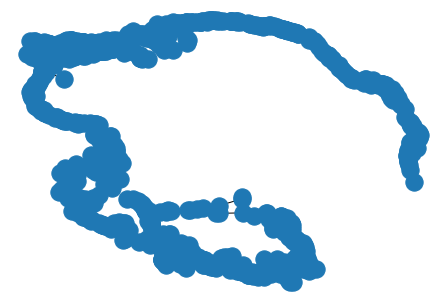

In [77]:
# Construct a MST only using the 750 points modified above
(graph_centerline, pointsCor3D_centerline) = getMSTFromDataPoint(points_centerline, drawMST=True, sampleNumber=5000)  

# constantly delete the node that only has one edge, until there are only two nodes only having one edge left,
# both of them are the endpoints of one singal path representing the colon

toRemove = []
removeCount = 0
removedNodeDict = defaultdict(list)

print("MST has", len(pointsCor3D_centerline), "nodes. Now begin to trim the graph.")

while (True):
    toRemove = []
    for node in graph_centerline.nodes():
        if(len(graph_centerline.edges(node)) == 1):
            removedNodeDict[list(graph_centerline.edges(node))[0][1]].append(node)
            toRemove.append(node)
    if(len(toRemove) == 2):
        break
    for node in toRemove:
        graph_centerline.remove_node(node)
        removeCount += 1
        toRemove = []
        
        
endpoints = toRemove
print("Done! Trimed", removeCount, "nodes. Now MST has", len(graph_centerline.nodes), "nodes left.")

print("Now begin reconstruct endpoints")
# now add back the nodes that got deleted during the triming
addBackChildren(endpoints[0], 0)
addBackChildren(endpoints[1], 0)

print("Done! Now MST has", len(graph_centerline.nodes), "nodes left.")

# Displat the points on the centerline

to_display = []
for node in graph_centerline.nodes:
    to_display.append(pointsCor3D_centerline[node])
displayPoints(to_display, 1.3)

# check if there is more than 2 endpoints
new_endpoints = []
for node in graph_centerline.nodes:
    if(len(graph_centerline.edges(node)) == 1):
       new_endpoints.append(node)
if(len(new_endpoints) != 2):
    print("Fatal error: multiple endpoints detected!")

# check if there is more than 2 path
path = list(nx.all_simple_paths(graph_centerline, source=new_endpoints[0], target=new_endpoints[1]))
if(len(path) != 1):
    print("Fatal error: multiple path detected!")
    
pointsInorder = path[0]

In [73]:
pointsCorInorder = []
for point in pointsInorder:
    pointsCorInorder.append(pointsCor3D_centerline[point])
np.savetxt("centerline.csv", pointsCorInorder, delimiter=" ")

In [52]:
np.savetxt("centerline.csv", pointsCorInorder, delimiter=",")

In [43]:
displayPoints(np.load("centerlineInorder.npy"), 1.3)

In [ ]:
c = curve()
for pointIndex in pointsInorder:
    c.append(pointCorToVector(pointsCor3D_centerline[pointIndex]))

In [66]:
toDisplay=[]
for node in graph_centerline.nodes():
    toDisplay.append(pointsCor3D_centerline[node])
displayPoints(toDisplay, 1.3)